# <center> Image Classification using CNN and Transfer Learning on Intel Dataset </center>

## Establishing Connection with Kaggle and Downloading dataset from Kaggle




In [ ]:
! pip install -q kaggle

In [ ]:
# generating an upload button to upload API token for establishing connection with Kaggle
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"swaradapathak","key":"0122cd4f102ccfde6a5847f9872440a2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Giving write permission to uploaded file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading Dataset from kaggle
! kaggle datasets download -d puneet6060/intel-image-classification

 96% 333M/346M [00:01<00:00, 206MB/s]
100% 346M/346M [00:01<00:00, 191MB/s]


In [ ]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from random import randint
from IPython.display import SVG # used for SVG(Scalable Vector Graphics) format

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import confusion_matrix as CM

import tensorflow as tf
import keras
import tensorflow.keras.layers as Layers
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
import tensorflow.keras.models as Models
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam # optimizers
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils # dataset loading, model visualization
from tensorflow.keras.utils import model_to_dot # graphical representation of a Keras model as a Graphviz dot graph.
#ReduceLRPlateau monitors Learning Rate
#ModelCheckpoint Saves the model or its weights at specified intervals
#CSVLogger saves epoch,train loss to a CSV File
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger


#importing libraries that would be required for loading images and image augmentation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

#Transfer learning
from tensorflow.keras.applications.inception_v3 import InceptionV3 # Importing Inception V3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # Importing MobileNet V2
from keras.applications import VGG16 # Importing VGG 16

#Gradio (UI)
import gradio as gr
from tensorflow.keras.preprocessing import image

#### Train data

In [ ]:
#Reading images
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred', # labels from directory
    label_mode='int', #Encode labels as int [0,1...,6]
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


#### Test Data

In [ ]:
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


### Plotting

In [ ]:
# getting class names of training data
class_names = df_train.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
# Dictionary comprehension
class_count = {class_name: 0 for class_name in class_names}
# initially assign 0 to each class name
class_count

for _, labels in df_train: # _ : placeholder
  for label in labels.numpy(): # converts tensor into numpy and iterating over labels
    class_name = class_names[label]
    class_count[class_name] += 1

# fetching count of each class
for class_name, count in class_count.items():
  print(f"{class_name}: {count}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [ ]:
# Converting into DataFrame
cc_df = pd.DataFrame(df_train.class_names).reset_index()
cc_df.rename(columns={'index': 'label', 0: 'class_name'}, inplace = True)
cc_df['class_name']=cc_df["class_name"].str.title()
cc_df['count']=class_count.values()
cc_df

,label,class_name,count
0,0,Buildings,2191
1,1,Forest,2271
2,2,Glacier,2404
3,3,Mountain,2512
4,4,Sea,2274
5,5,Street,2382


In [ ]:
#converting the dataset to a NumPy iterator which allows iterate over dataset
data_iterator = df_train.as_numpy_iterator()

In [ ]:
batch =data_iterator.next() #returns 2 things: batch[0]-> Images and batch[1]-> Labels

In [ ]:
for image_batch, labels_batch in df_train:
    print(image_batch.shape) # batch_size, image size, channels(rgb)
    print(labels_batch.shape) # batch size
    break

(32, 150, 150, 3)
(32,)


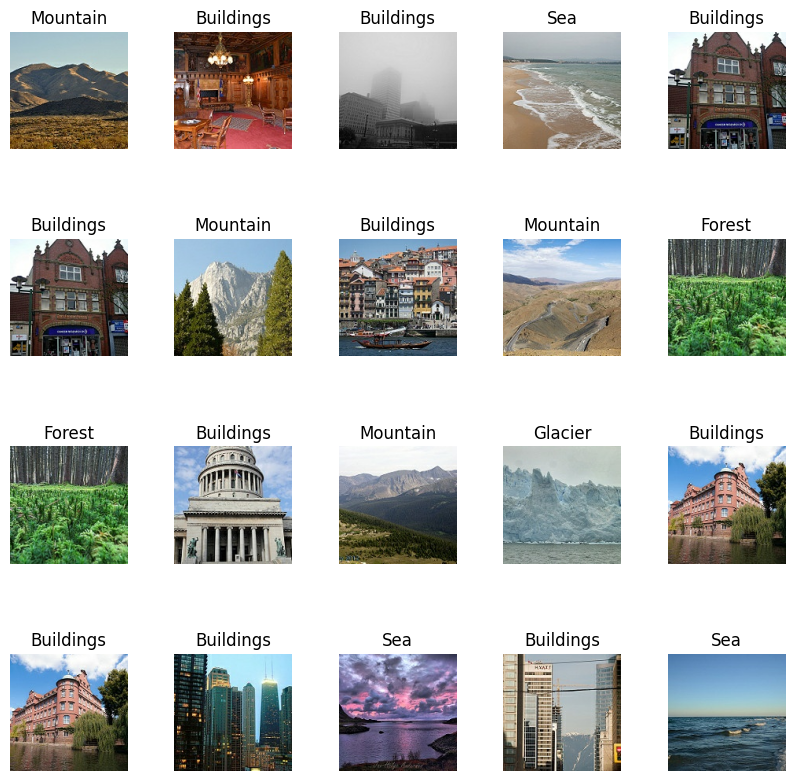

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10)) # creating subplot array
for i in range(4):
    for j in range(5):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int)) # print images
        ax[i, j].set_title(cc_df["class_name"][batch[1][index]]) # print associated titles
        ax[i,j].axis('off') # no axis
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

# fig, ax = plt.subplots(nrows=len(cc_df["class_name"]), ncols=3, figsize=(20, 20))

# for i, class_name in enumerate(cc_df["class_name"]):
#     indices = np.where(batch[1] == i)[0][:3]
#     for j, index in enumerate(indices):
#         ax[i, j].imshow(batch[0][index].astype(int))
#         ax[i, j].set_title(class_name)
#         ax[i, j].axis('off')

# plt.subplots_adjust(wspace=0.4, hspace=0.4)
# plt.show()

### Custom Functions

#### defining custom function for Model Accuracy

In [ ]:
def model_accuracy(model_name):
  plt.plot(model_name.history['accuracy'])
  plt.plot(model_name.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

#### defining custom function for Model Loss

In [ ]:
def model_loss(model_name):
  plt.plot(model_name.history['loss'])
  plt.plot(model_name.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()


# CCN Model

#### Model 1

In [ ]:
model1 = Models.Sequential()

#Convolution
model1.add(Layers.Conv2D(200, kernel_size=(5,5),activation='relu',input_shape=(150,150,3)))
model1.add(Layers.MaxPool2D(5,5))
model1.add(Layers.Flatten())

#ANN
model1.add(Layers.Dense(180,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model1.add(Layers.Dense(6,activation='softmax'))

# compiling the model and adding the optimizer
model1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 200)     15200     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 200)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 168200)            0         
                                                                 
 dense (Dense)               (None, 180)               30276180  
                                                                 
 dense_1 (Dense)             (None, 6)                 1086      
                                                                 
Total params: 30292466 (115.56 MB)
Trainable params: 30292466 (115.56 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
# fitting the model
trained_model1 = model1.fit(df_train, validation_data = df_test, batch_size=32, validation_split=0.3, epochs =10)

Epoch 1/10
439/439 [==============================] - 28s 55ms/step - loss: 37.6404 - accuracy: 0.4220 - val_loss: 1.3416 - val_accuracy: 0.4653
Epoch 2/10
439/439 [==============================] - 23s 52ms/step - loss: 0.9594 - accuracy: 0.6250 - val_loss: 1.4248 - val_accuracy: 0.4983
Epoch 3/10
439/439 [==============================] - 23s 52ms/step - loss: 0.6554 - accuracy: 0.7493 - val_loss: 2.0097 - val_accuracy: 0.4963
Epoch 4/10
439/439 [==============================] - 23s 52ms/step - loss: 0.5101 - accuracy: 0.8140 - val_loss: 2.3544 - val_accuracy: 0.4920
Epoch 5/10
439/439 [==============================] - 23s 53ms/step - loss: 0.5260 - accuracy: 0.8218 - val_loss: 2.4716 - val_accuracy: 0.4867
Epoch 6/10
439/439 [==============================] - 23s 53ms/step - loss: 0.4027 - accuracy: 0.8572 - val_loss: 2.9661 - val_accuracy: 0.4993
Epoch 7/10
439/439 [==============================] - 24s 53ms/step - loss: 0.3759 - accuracy: 0.8733 - val_loss: 3.3719 - val_accuracy

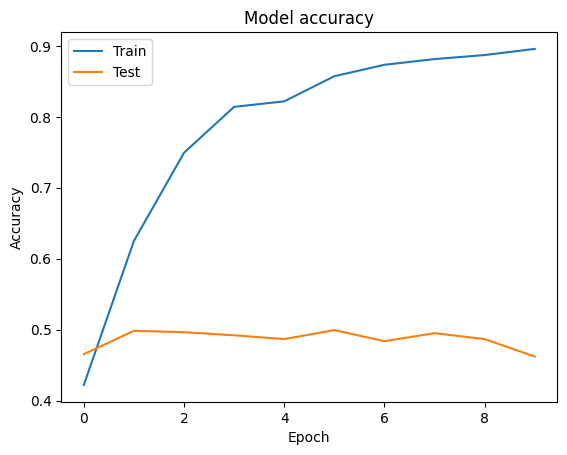

In [ ]:
model_accuracy(trained_model1)

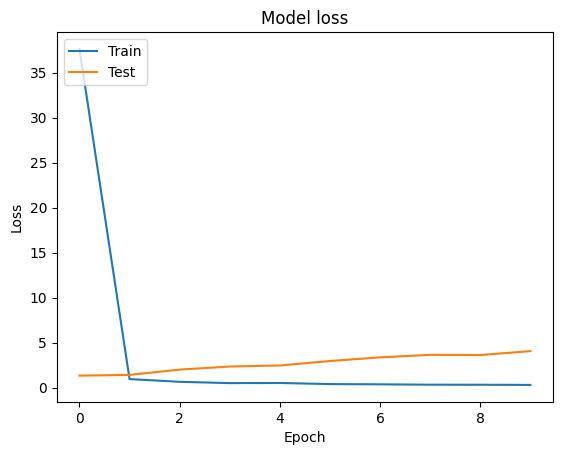

In [ ]:
model_loss(trained_model1)

#### Model 2

In [ ]:
model2 = Models.Sequential()

#Convolution
model2.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model2.add(Layers.Conv2D(180, kernel_size=(3,3),activation='relu'))
model2.add(Layers.MaxPool2D(3,3))
model2.add(Layers.Flatten())

#ANN
model2.add(Layers.Dense(180,activation='relu'))
model2.add(Layers.Dense(120,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model2.add(Layers.Dense(6,activation='softmax'))

# compiling the model and adding the optimizer
model2.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 200)     5600      
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 180)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 414720)            0         
                                                                 
 dense_2 (Dense)             (None, 180)               74649780  
                                                                 
 dense_3 (Dense)             (None, 120)               21720     
                                                      

In [ ]:
# fitting the model
trained_model2 = model2.fit(df_train, validation_data = df_test, batch_size=32, validation_split=0.3, epochs =10)

Epoch 1/10
439/439 [==============================] - 145s 306ms/step - loss: 14.9077 - accuracy: 0.3127 - val_loss: 1.3597 - val_accuracy: 0.3997
Epoch 2/10
439/439 [==============================] - 132s 300ms/step - loss: 1.1205 - accuracy: 0.5214 - val_loss: 1.2938 - val_accuracy: 0.4883
Epoch 3/10
439/439 [==============================] - 131s 299ms/step - loss: 0.7887 - accuracy: 0.6699 - val_loss: 1.6385 - val_accuracy: 0.4697
Epoch 4/10
439/439 [==============================] - 131s 299ms/step - loss: 0.5376 - accuracy: 0.7754 - val_loss: 1.8288 - val_accuracy: 0.4747
Epoch 5/10
439/439 [==============================] - 131s 299ms/step - loss: 0.4170 - accuracy: 0.8325 - val_loss: 2.0417 - val_accuracy: 0.4787
Epoch 6/10
439/439 [==============================] - 131s 298ms/step - loss: 0.3397 - accuracy: 0.8658 - val_loss: 2.4088 - val_accuracy: 0.4723
Epoch 7/10
439/439 [==============================] - 131s 299ms/step - loss: 0.2786 - accuracy: 0.8908 - val_loss: 2.8098 

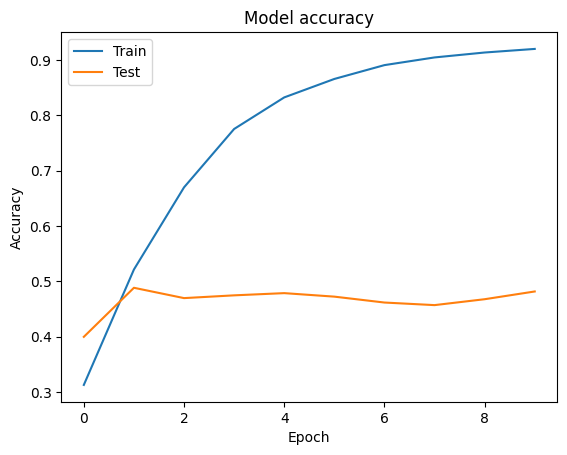

In [ ]:
model_accuracy(trained_model2)

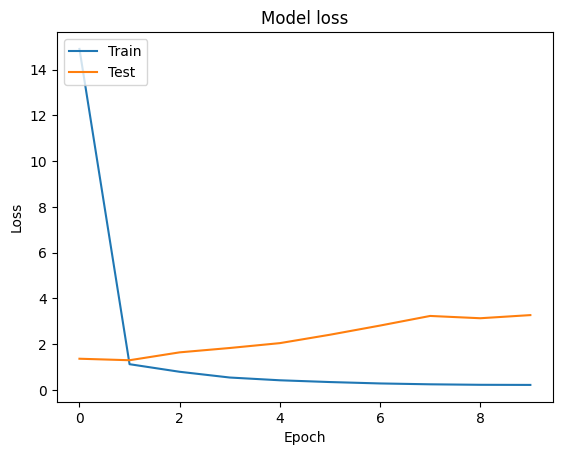

In [ ]:
model_loss(trained_model2)

#### Model 3

In [ ]:
model3 = Models.Sequential()

#Convolution
model3.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model3.add(Layers.Conv2D(180, kernel_size=(3,3),activation='relu'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Conv2D(160, kernel_size=(3,3),activation='tanh'))
model3.add(Layers.Conv2D(140, kernel_size=(3,3),activation='tanh'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Flatten())

#ANN
model3.add(Layers.Dense(180,activation='relu'))
model3.add(Layers.Dropout(rate=0.5))
model3.add(Layers.Dense(120,activation='tanh'))
model3.add(Layers.Dense(60,activation='tanh'))

#O/P Layer 6 becuase - 6 classes
model3.add(Layers.Dense(6,activation='softmax'))

# compiling the model and adding the optimizer
model3.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 200)     5600      
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 180)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 160)       259360    
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 140)       201740    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 140)       0         
 g2D)                                                 

In [ ]:
# fitting the model
trained_model3 = model3.fit(df_train, validation_data = df_test, batch_size=50, validation_split=0.3, epochs =10)

Epoch 1/10
439/439 [==============================] - 156s 342ms/step - loss: 1.8571 - accuracy: 0.1668 - val_loss: 1.7989 - val_accuracy: 0.1843
Epoch 2/10
439/439 [==============================] - 147s 335ms/step - loss: 1.8170 - accuracy: 0.1607 - val_loss: 1.8055 - val_accuracy: 0.1670
Epoch 3/10
439/439 [==============================] - 147s 335ms/step - loss: 1.8059 - accuracy: 0.1653 - val_loss: 1.8052 - val_accuracy: 0.1843
Epoch 4/10
439/439 [==============================] - 149s 340ms/step - loss: 1.8018 - accuracy: 0.1677 - val_loss: 1.8021 - val_accuracy: 0.1843
Epoch 5/10
439/439 [==============================] - 147s 334ms/step - loss: 1.8001 - accuracy: 0.1689 - val_loss: 1.7967 - val_accuracy: 0.1843
Epoch 6/10
439/439 [==============================] - 147s 334ms/step - loss: 1.7976 - accuracy: 0.1724 - val_loss: 1.7993 - val_accuracy: 0.1843
Epoch 7/10
439/439 [==============================] - 147s 334ms/step - loss: 1.7980 - accuracy: 0.1714 - val_loss: 1.7971 -

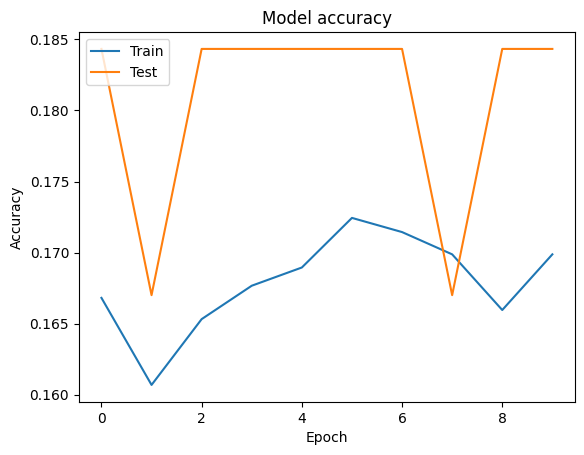

In [ ]:
model_accuracy(trained_model3)

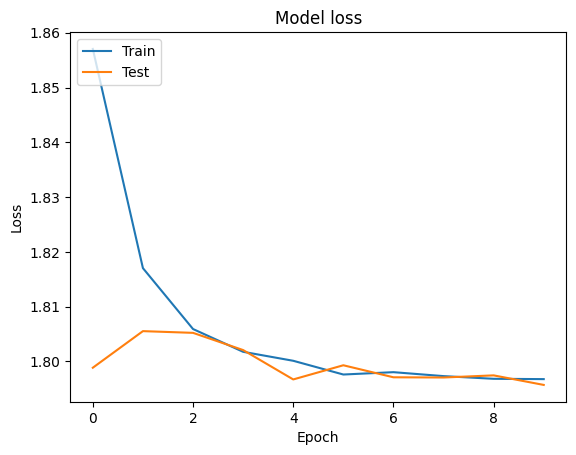

In [ ]:
model_loss(trained_model3)

#### Model 4

In [ ]:
model4 = Models.Sequential()

#Convolution
model4.add(Layers.Conv2D(200, kernel_size=(5,5),activation='leaky_relu',input_shape=(150,150,3)))
model4.add(Layers.Conv2D(150, kernel_size=(5,5),activation='leaky_relu'))
model4.add(Layers.MaxPool2D(5,5))
model4.add(Layers.BatchNormalization(axis=-1))

model4.add(Layers.Conv2D(150, kernel_size=(3,3),activation='leaky_relu'))
model4.add(Layers.Conv2D(100, kernel_size=(3,3),activation='leaky_relu'))
model4.add(Layers.MaxPool2D(3,3))
model4.add(Layers.BatchNormalization(axis=-1))

model4.add(Layers.Flatten())

#ANN
model4.add(Layers.Dense(200,activation='leaky_relu'))
model4.add(Layers.Dropout(rate=0.2))
model4.add(Layers.Dense(150,activation='leaky_relu'))
model4.add(Layers.Dropout(rate=0.1))
model4.add(Layers.Dense(100,activation='leaky_relu'))

#O/P Layer 6 becuase - 6 classes
model4.add(Layers.Dense(6,activation='softmax'))

# compiling the model and adding the optimizer
model4.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 200)     15200     
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 150)     750150    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 150)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 28, 28, 150)       600       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 150)       202650    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 100)       1

In [ ]:
# defining parameters for early stopping
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
# fitting the model
trained_model4 = model4.fit(df_train, validation_data = df_test,validation_split=0.3, batch_size=50, epochs =10,callbacks=early_stopping)

Epoch 1/10
439/439 [==============================] - 190s 374ms/step - loss: 0.8634 - accuracy: 0.6769 - val_loss: 0.7505 - val_accuracy: 0.7337
Epoch 2/10
439/439 [==============================] - 147s 334ms/step - loss: 0.5796 - accuracy: 0.7891 - val_loss: 0.6001 - val_accuracy: 0.7917
Epoch 3/10
439/439 [==============================] - 147s 336ms/step - loss: 0.4658 - accuracy: 0.8323 - val_loss: 0.4939 - val_accuracy: 0.8273
Epoch 4/10
439/439 [==============================] - 147s 335ms/step - loss: 0.3976 - accuracy: 0.8609 - val_loss: 0.5584 - val_accuracy: 0.8077
Epoch 5/10
439/439 [==============================] - 147s 335ms/step - loss: 0.3327 - accuracy: 0.8833 - val_loss: 0.5400 - val_accuracy: 0.8217
Epoch 6/10
439/439 [==============================] - 148s 336ms/step - loss: 0.2790 - accuracy: 0.9013 - val_loss: 0.6429 - val_accuracy: 0.7920
Epoch 7/10
439/439 [==============================] - 147s 336ms/step - loss: 0.2333 - accuracy: 0.9185 - val_loss: 0.4705 -

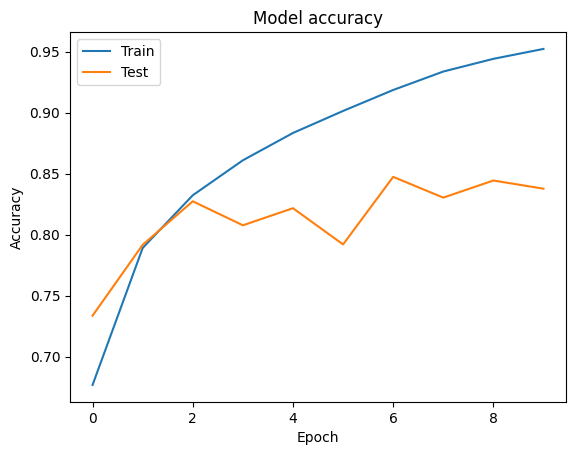

In [ ]:
model_accuracy(trained_model4)

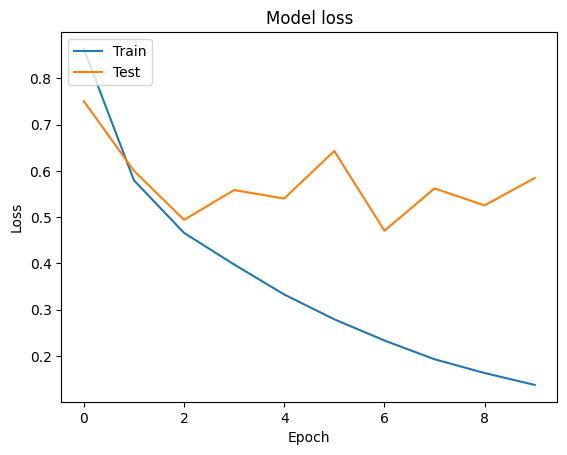

In [ ]:
model_loss(trained_model4)

In [ ]:
#Saving the best model of Basic CNN
model4.save("cnn_model.h5")

In [ ]:
SVG(model_to_dot(model4).create(prog='dot', format='svg'))
Utils.plot_model(model4,to_file='model.png',show_shapes=True)

#### Model 5

In [ ]:
model5 = Models.Sequential()

#Convolution
model5.add(Layers.Conv2D(100, kernel_size=(5,5),activation='relu',input_shape=(150,150,3)))
model5.add(Layers.Conv2D(80,kernel_size=(5,5),activation ='relu'))
model5.add(Layers.MaxPool2D(5,5))

model5.add(Layers.BatchNormalization(axis=-1))

model5.add(Layers.Conv2D(150, kernel_size=(3,3),activation='relu'))
model5.add(Layers.Conv2D(100, kernel_size=(3,3),activation='relu'))
model5.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model5.add(Layers.MaxPool2D(3,3))

model5.add(Layers.BatchNormalization(axis=-1))

model5.add(Layers.Flatten())

#ANN
model5.add(Layers.Dense(150,activation='relu'))
model5.add(Layers.Dropout(rate=0.25))
model5.add(Layers.Dense(100,activation='relu'))
model5.add(Layers.Dropout(rate=0.1))
model5.add(Layers.Dense(50,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model5.add(Layers.Dense(6,activation='softmax'))

# compiling the model and adding the optimizer
model5.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 100)     7600      
                                                                 
 conv2d_5 (Conv2D)           (None, 142, 142, 80)      200080    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 80)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 28, 28, 80)        320       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 150)       108150    
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 100)      

In [ ]:
# defining the parameters for early stopping
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
# fitting the model
trained_model5 = model5.fit(df_train, validation_data = df_test,validation_split=0.3, batch_size=50, epochs =10, callbacks = early_stopping)

Epoch 1/10
439/439 [==============================] - 71s 136ms/step - loss: 1.1156 - accuracy: 0.5658 - val_loss: 4.1044 - val_accuracy: 0.2247
Epoch 2/10
439/439 [==============================] - 53s 120ms/step - loss: 0.8101 - accuracy: 0.6992 - val_loss: 0.8774 - val_accuracy: 0.6900
Epoch 3/10
439/439 [==============================] - 52s 118ms/step - loss: 0.6936 - accuracy: 0.7505 - val_loss: 1.1985 - val_accuracy: 0.5547
Epoch 4/10
439/439 [==============================] - 53s 119ms/step - loss: 0.6004 - accuracy: 0.7847 - val_loss: 0.8524 - val_accuracy: 0.6757
Epoch 5/10
439/439 [==============================] - 52s 118ms/step - loss: 0.5339 - accuracy: 0.8088 - val_loss: 0.5370 - val_accuracy: 0.8000
Epoch 6/10
439/439 [==============================] - 52s 118ms/step - loss: 0.4917 - accuracy: 0.8236 - val_loss: 0.5821 - val_accuracy: 0.7883
Epoch 7/10
439/439 [==============================] - 52s 118ms/step - loss: 0.4541 - accuracy: 0.8415 - val_loss: 0.5188 - val_ac

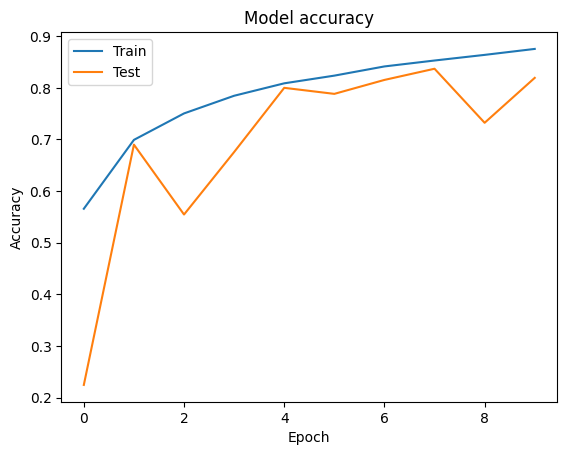

In [ ]:
model_accuracy(trained_model5)

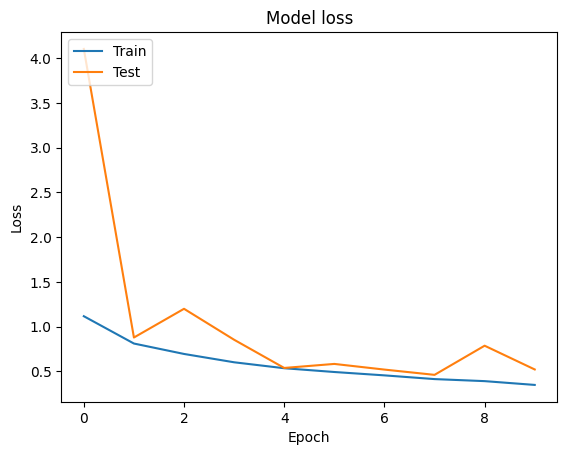

In [ ]:
model_loss(trained_model5)

# Transfer Learning

## Common Data Augmentation for transfer learning model

In [ ]:
#For train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,#displaces each point in a fixed direction
    zoom_range=0.2,
    fill_mode='nearest'#specifies how these missing pixels will be filled
)

In [ ]:
#for test data
test_datagen = ImageDataGenerator(rescale = 1./255)

## Inception V3

In [ ]:
#prepare a directory of images for training
train_generator1 = train_datagen.flow_from_directory(
    "/content/seg_train/seg_train",
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical' # label array - One Hot encoding format
)

Found 14034 images belonging to 6 classes.


In [ ]:
train_generator1.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
#define function to get labels
def get_Label(number):
    labels = { 0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}
    return labels[number]

In [ ]:
#prepare a directory of images for testing
test_generator1 = test_datagen.flow_from_directory("/content/seg_test/seg_test",
                                                 target_size = (299, 299),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
test_generator1.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
#size required by Inception V3
image_size=[299,299]

# initializing Inception V3 model
# include_top specifies whether to include the fully connected layer at the top of the network
inception=InceptionV3(input_shape=image_size+[3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Not training on previous layers. Therefore, setting it False
for layer in inception.layers:
    layer.trainable=False

In [ ]:
# Flattening the incoming Inception V3 layer
x=Flatten()(inception.output)

# O/P Layer num_classes i.e 6 becuase - 6 classes
prediction=Dense(6,activation='softmax')(x)

model_incept =Model(inputs=inception.input,outputs=prediction)

# compiling the model and adding the optimizer
model_incept.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_incept.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
# defining Early stopping
early_stopping=EarlyStopping(patience=4,verbose=1,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(factor=0.1,patience=3,verbose=1)

callbacks = [early_stopping, reduce_lr]

In [ ]:
print(len(train_generator1))
print(len(test_generator1))

110
24


In [ ]:
trained_model_inception = model_incept.fit(train_generator1,
                                           validation_data=test_generator1,
                                           epochs=10,
                                           steps_per_epoch=len(train_generator1),
                                           validation_steps=len(test_generator1),
                                           callbacks=callbacks
                                           )

Epoch 1/10
110/110 [==============================] - 365s 3s/step - loss: 3.5234 - accuracy: 0.7921 - val_loss: 0.7963 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 306s 3s/step - loss: 1.1633 - accuracy: 0.8662 - val_loss: 1.0102 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 305s 3s/step - loss: 1.2976 - accuracy: 0.8676 - val_loss: 1.0419 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 1.1721 - accuracy: 0.8840
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
110/110 [==============================] - 308s 3s/step - loss: 1.1721 - accuracy: 0.8840 - val_loss: 1.1508 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - 315s 3s/step - loss: 0.8058 - accuracy: 0.9091 - val_loss: 0.8244 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 5: early stopping


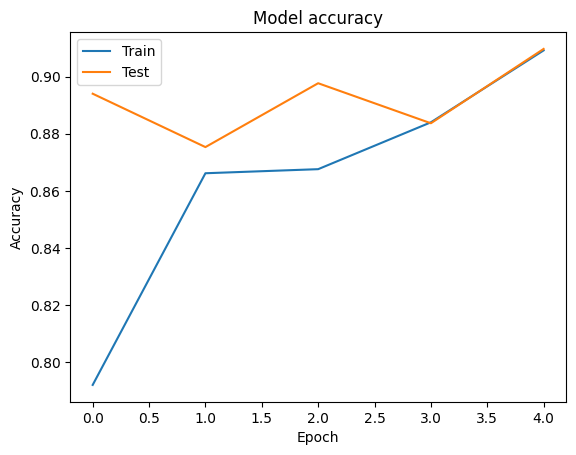

In [ ]:
model_accuracy(trained_model_inception)

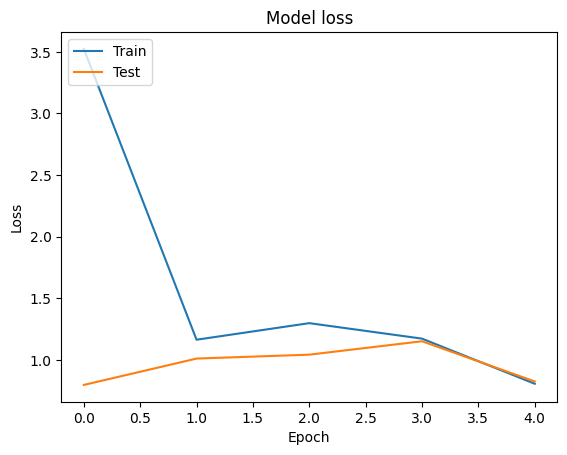

In [ ]:
model_loss(trained_model_inception)

In [ ]:
#saving the trained model
model_incept.save("inception_v3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## MobileNet V2

In [ ]:
#prepare a directory of images for training
train_generator2 = train_datagen.flow_from_directory("/content/seg_train/seg_train",
                                                     target_size=(150, 150),
                                                     batch_size=128,
                                                     class_mode='sparse'
                                                     )


Found 14034 images belonging to 6 classes.


In [ ]:
#prepare a directory of images for testing
test_generator2 = test_datagen.flow_from_directory("/content/seg_test/seg_test",
                                                 target_size = (150, 150),
                                                 batch_size = 128,
                                                 class_mode = 'sparse'
                                                 )

Found 3000 images belonging to 6 classes.


In [ ]:
# image size required by MobileNet V2
image_size=[224,224]

# initializing the MobileNet V2 model
# include_top specifies whether to include the fully connected layer at the top of the network
mobileNet = MobileNetV2(input_shape=image_size+[3],weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Not training on previous layers. Therefore, setting it False
for layer in mobileNet.layers:
    layer.trainable=False

In [ ]:
model_mob = Sequential()
model_mob.add(mobileNet)
model_mob.add(GlobalAveragePooling2D())
# O/P Layer num_classes i.e 6 becuase - 6 classes
model_mob.add(Dense(units=6, activation="softmax"))

# compiling the model and adding the optimizer
model_mob.compile(optimizer=RMSprop(learning_rate=0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model_mob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
csv_logger = CSVLogger('train_log.csv', separator=',')

callbacks=[model_check, early, reduce_lr, csv_logger]

In [ ]:
print(len(train_generator2))
print(len(test_generator2))

110
24


In [ ]:
trained__model_mobilenet = model_mob.fit(train_generator2,
                                     validation_data=test_generator2,
                                     epochs=10,
                                     steps_per_epoch=len(train_generator2),
                                     validation_steps=len(test_generator2),
                                     callbacks=callbacks
                                     )

Epoch 1/10
110/110 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7718

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 105s 906ms/step - loss: 0.6121 - accuracy: 0.7718 - val_loss: 0.3421 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 89s 810ms/step - loss: 0.4068 - accuracy: 0.8504 - val_loss: 0.3111 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 87s 792ms/step - loss: 0.3674 - accuracy: 0.8677 - val_loss: 0.3219 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - 88s 804ms/step - loss: 0.3541 - accuracy: 0.8735 - val_loss: 0.3144 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - 88s 797ms/step - loss: 0.3488 - accuracy: 0.8710 - val_loss: 0.2945 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 6/10
110/110 [==============================] - 87s 793ms/step - loss: 0.3395 - accuracy: 0.8738 - val_loss: 0.2782 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 7/10
110/110 [==============================] - 86s 780m

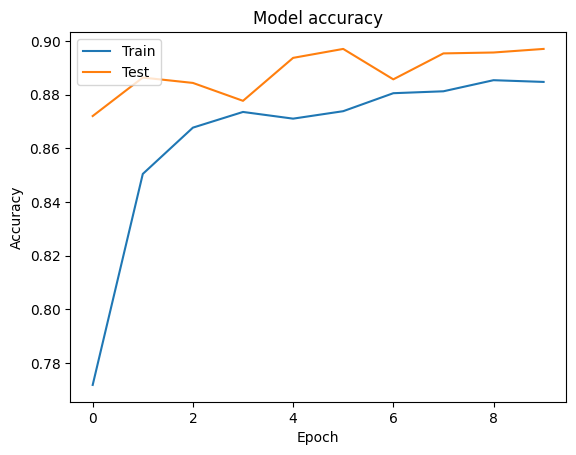

In [ ]:
model_accuracy(trained__model_mobilenet)

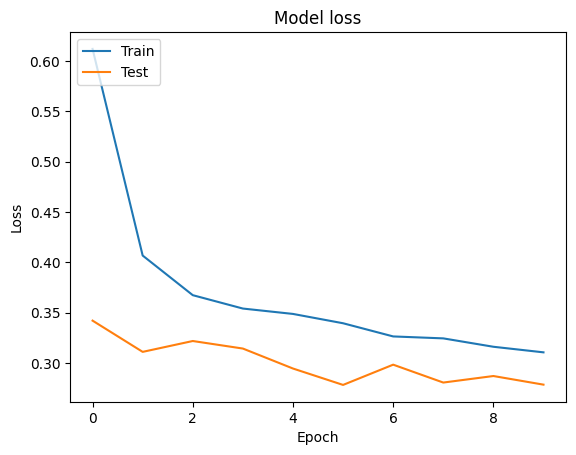

In [ ]:
model_loss(trained__model_mobilenet)

In [ ]:
model_mob.save("mobilenet_v2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## VGG 16

In [ ]:
#prepare a directory of images for training
train_generator3 = train_datagen.flow_from_directory("/content/seg_train/seg_train",
                                                     target_size=(224, 224),
                                                     batch_size=128,
                                                     class_mode='sparse'
                                                     )


Found 14034 images belonging to 6 classes.


In [ ]:
#prepare a directory of images for testing
test_generator3 = test_datagen.flow_from_directory("/content/seg_test/seg_test",
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'sparse'
                                                 )

Found 3000 images belonging to 6 classes.


In [ ]:
# image size required by VGG 16
image_size=[224,224]

# initializing VGG 16 model
vgg = VGG16(input_shape=image_size+[3], weights = 'imagenet', include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Not training on previous layers. Therefore, setting it False
for layer in vgg.layers:
    layer.trainable=False

In [ ]:
model_vgg = Models.Sequential()

model_vgg.add(Layers.Flatten())
model_vgg.add(Layers.Dense(250, activation='relu'))
model_vgg.add(Layers.Dropout(0.5))
# O/P Layer 6 becuase - 6 classes
model_vgg.add(Layers.Dense(6, activation='softmax'))

# compiling the model and adding the Optimizer
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer = Optimizer.Nadam(learning_rate = 2e-5), metrics=['accuracy'])

In [ ]:
# defining early stopping
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
# fitting the model
trained__model_vgg = model_vgg.fit(train_generator3,
                                     validation_data=test_generator3,
                                     epochs=10,
                                     steps_per_epoch=len(train_generator3),
                                     validation_steps=len(test_generator3),
                                     callbacks=early_stopping
                                     )

Epoch 1/10
110/110 [==============================] - 179s 2s/step - loss: 1.7021 - accuracy: 0.3141 - val_loss: 1.4910 - val_accuracy: 0.4493
Epoch 2/10
110/110 [==============================] - 165s 1s/step - loss: 1.5268 - accuracy: 0.3846 - val_loss: 1.4600 - val_accuracy: 0.4750
Epoch 3/10
110/110 [==============================] - 167s 2s/step - loss: 1.4899 - accuracy: 0.4033 - val_loss: 1.4249 - val_accuracy: 0.4810
Epoch 4/10
110/110 [==============================] - 167s 2s/step - loss: 1.4759 - accuracy: 0.4137 - val_loss: 1.3876 - val_accuracy: 0.4963
Epoch 5/10
110/110 [==============================] - 167s 2s/step - loss: 1.4641 - accuracy: 0.4204 - val_loss: 1.3692 - val_accuracy: 0.5137
Epoch 6/10
110/110 [==============================] - 169s 2s/step - loss: 1.4538 - accuracy: 0.4217 - val_loss: 1.3731 - val_accuracy: 0.4993
Epoch 7/10
110/110 [==============================] - 168s 2s/step - loss: 1.4433 - accuracy: 0.4303 - val_loss: 1.3510 - val_accuracy: 0.5063

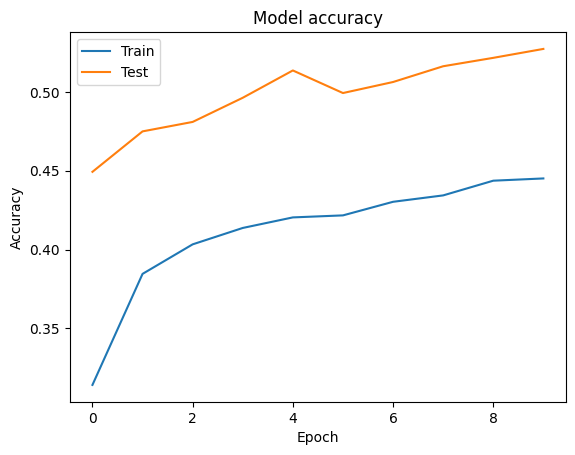

In [ ]:
model_accuracy(trained__model_vgg)

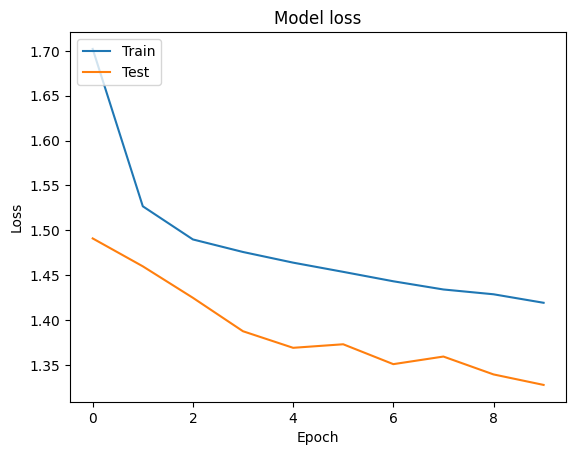

In [ ]:
model_loss(trained__model_vgg)

In [ ]:
# saving the model
model_vgg.save("vgg_16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
